In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder

In [2]:
print(os.getcwd()) 

C:\Users\hi\Desktop\DeepLearning


In [3]:
# 파일 경로 재설정
base_dir = os.chdir(os.getcwd() + "/img-fashion")
print(os.getcwd())

C:\Users\hi\Desktop\DeepLearning\img-fashion


In [4]:
data_list = glob('*.jpg')
print('파일 개수 >> ', len(data_list))
print('파일 목록 타입 >> ', type(data_list))

파일 개수 >>  7652
파일 목록 타입 >>  <class 'list'>


In [5]:
token = text_to_word_sequence(data_list[0])
print(token)

['blouse', '1', 'jpg']


In [6]:
label = []
for x in data_list:
    token = text_to_word_sequence(x)
    label.append(token[0])
print(len(label))

7652


In [7]:
items = label
encoder = LabelEncoder()
label = encoder.fit_transform(items)
label

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

In [8]:
data_height = 150
data_width = 150
channel_n = 3

In [9]:
def make_file(dat_height, data_width, channel_n, data_list_len):
    label = []
    images = np.zeros((data_list_len, dat_height, data_width, channel_n))
    
    for i, image in enumerate(data_list):
        
        token = text_to_word_sequence(image)
        label.append(token[0])
        
        image = cv2.imread(image)
        image = cv2.resize(image, (dat_height, data_width)) / 255
        
        images[i, :, :, :] = image
    label = np.array(label)
    return (label, images)    

In [10]:
label, images = make_file(data_height, data_width, channel_n, len(data_list))

In [11]:
items = label
encoder = LabelEncoder()
label = encoder.fit_transform(items)
label, len(label) 

(array([0, 0, 0, ..., 7, 7, 7], dtype=int64), 7652)

In [12]:
x = images
y = label

X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size= 0.2,
                                                    random_state=55
                                                   )
print(X_train.shape, X_test.shape)

(6121, 150, 150, 3) (1531, 150, 150, 3)


In [13]:
## 딥러닝 모델을 만들어보자.
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models

In [14]:
model = models.Sequential()
## 특성추출 레이어를 쌓아준다.
model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(data_height, data_width, 3)))
model.add(MaxPool2D((2,2)))#최대값으로 요약
model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(data_height, data_width, 3)))
model.add(MaxPool2D((2,2)))#최대값으로 요약
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPool2D((2,2)))#최대값으로 요약

## 딥러닝 학습 레이어를 쌓아준다.
## 입력 -- 히든 -- 출력 순서대로 쌓아준다.
## 입력(1개)--1차원이어야함
model.add(Flatten())#이미지 데이터를 1차원으로 만들어주는 객체
## 히든(N개)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.5))#오버피팅 되는 것을 막기 위해 공부한거 드랍아웃 해줌

## 출력(1개)--딥러닝으로 하는 학습의 종류에 따라 다르게 써주어야 함!
## 이진 분류인경우(1, sigmoid)
## 다중 분류인경우(1, softmax)
## 회귀인 경우(1, linear)
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [15]:
# Compiling the CNN
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [16]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cp = ModelCheckpoint('fashion_cnn_1.h5')

In [17]:
cnn_history = model.fit( X_train, 
                       y_train,                
                       batch_size=50,
                       epochs=30,
                       validation_data = (X_test, y_test),
                       callbacks = [es, cp],
                       verbose=2
                       )

Epoch 1/30
123/123 - 27s - loss: 1.9647 - accuracy: 0.2232 - val_loss: 1.7128 - val_accuracy: 0.4624 - 27s/epoch - 216ms/step
Epoch 2/30
123/123 - 26s - loss: 1.6710 - accuracy: 0.3588 - val_loss: 1.5661 - val_accuracy: 0.4278 - 26s/epoch - 210ms/step
Epoch 3/30
123/123 - 26s - loss: 1.5341 - accuracy: 0.4187 - val_loss: 1.4130 - val_accuracy: 0.5095 - 26s/epoch - 215ms/step
Epoch 4/30
123/123 - 26s - loss: 1.4415 - accuracy: 0.4463 - val_loss: 1.2907 - val_accuracy: 0.5663 - 26s/epoch - 212ms/step
Epoch 5/30
123/123 - 26s - loss: 1.3502 - accuracy: 0.4833 - val_loss: 1.2131 - val_accuracy: 0.5859 - 26s/epoch - 214ms/step
Epoch 6/30
123/123 - 26s - loss: 1.2606 - accuracy: 0.5297 - val_loss: 1.1520 - val_accuracy: 0.5761 - 26s/epoch - 208ms/step
Epoch 7/30
123/123 - 27s - loss: 1.1733 - accuracy: 0.5517 - val_loss: 1.0267 - val_accuracy: 0.6525 - 27s/epoch - 215ms/step
Epoch 8/30
123/123 - 26s - loss: 1.0814 - accuracy: 0.5803 - val_loss: 0.9867 - val_accuracy: 0.6453 - 26s/epoch - 209

In [18]:
test_result = model.evaluate(X_test, y_test)
test_result

48/48 [==============================] - 2s 34ms/step - loss: 0.9867 - accuracy: 0.6453


[0.9867267608642578, 0.6453298330307007]

In [19]:
print('test acc: ', round(test_result[1]*100, 2))

test acc:  64.53


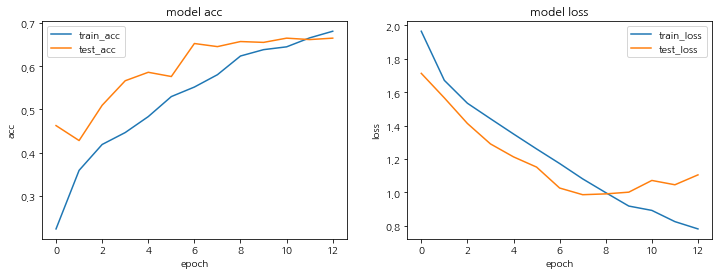

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])

In [21]:
## 모델 시각화
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

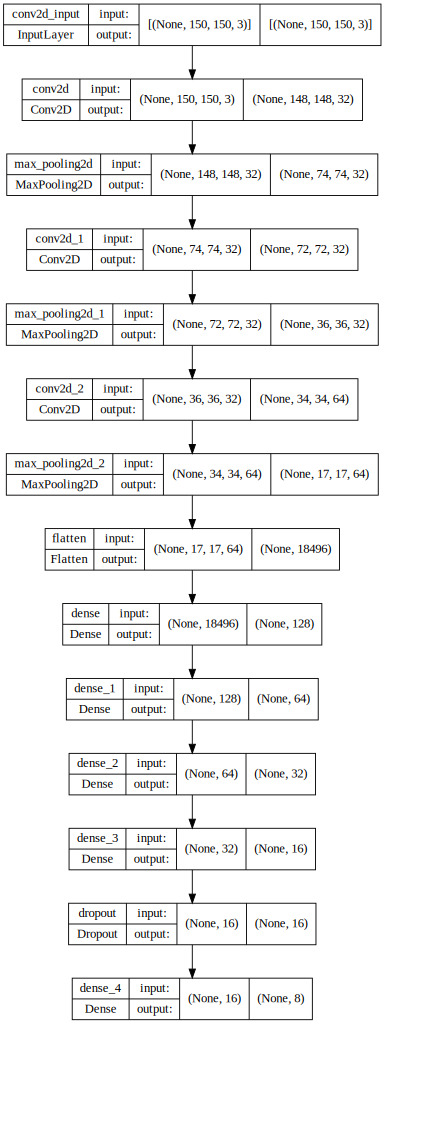

In [24]:
%matplotlib inline
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [25]:
## 모델 저장
from keras.models import load_model
model.save('fashion_model.h5')

In [13]:
from keras.models import load_model
model = load_model('fashion_model.h5')

In [14]:
final_result = model.predict(X_test)
final_result[:10]

array([[6.91034794e-02, 6.50208890e-02, 1.31614432e-01, 1.41493589e-01,
        7.88800269e-02, 4.04762685e-01, 7.41712004e-02, 3.49537060e-02],
       [3.47558290e-01, 8.13990831e-03, 1.72695890e-01, 3.80113517e-04,
        7.37064634e-04, 1.61936171e-02, 3.84684622e-01, 6.96104914e-02],
       [1.22105349e-02, 5.09074450e-01, 4.23753411e-02, 4.55468334e-02,
        2.11122609e-03, 3.78064901e-01, 5.51498914e-03, 5.10181068e-03],
       [4.76161800e-02, 1.12026150e-03, 3.72642317e-05, 3.78495368e-09,
        2.02644674e-08, 7.89000296e-07, 8.67034716e-04, 9.50358450e-01],
       [1.63088173e-01, 1.61489472e-03, 5.05733132e-01, 4.44669044e-04,
        1.18106995e-02, 2.97696982e-02, 2.64997929e-01, 2.25408506e-02],
       [3.56169850e-01, 6.63307905e-02, 8.09908286e-02, 2.16403836e-03,
        1.45635812e-03, 1.85326263e-02, 2.55516499e-01, 2.18839005e-01],
       [4.78766933e-02, 8.65614593e-01, 2.32301708e-02, 6.74126204e-04,
        2.10560785e-04, 3.18778008e-02, 1.05510829e-02, 1.

In [15]:
y_list = y_test.tolist()

In [16]:
y_list_0 = y_list.count(0)
print('blouse: ', y_list_0, '개')
y_list_1 = y_list.count(1)
print('dress:', y_list_1, '개')
y_list_2 = y_list.count(2)
print('jacket:', y_list_2, '개')
y_list_3 = y_list.count(3)
print('pants:', y_list_3, '개')
y_list_4 = y_list.count(4)
print('shorts:', y_list_4, '개')
y_list_5 = y_list.count(5)
print('skirt:', y_list_5, '개')
y_list_6 = y_list.count(6)
print('sweater:', y_list_6, '개')
y_list_7 = y_list.count(7)
print('Tshirt', y_list_7, '개')

blouse:  214 개
dress: 185 개
jacket: 195 개
pants: 177 개
shorts: 190 개
skirt: 201 개
sweater: 178 개
Tshirt 191 개


In [43]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [45]:
predictions = probability_model.predict(X_test)

In [46]:
predictions[0]

array([0.11743015, 0.1169517 , 0.12500511, 0.12624618, 0.11858384,
       0.1642686 , 0.11802676, 0.11348765], dtype=float32)

In [47]:
np.argmax(predictions[0])

5

In [48]:
y_test[0]

5

In [64]:
class_names = ['blouse', 'dress', 'jacket', 'pants', 'shorts',
               'skirt', 'sweater', 'Tshirt']

In [82]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("'예측: {}'      실제: {}'".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)

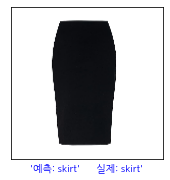

In [79]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.show()

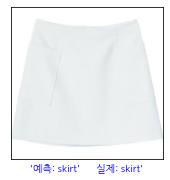

In [80]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.show()

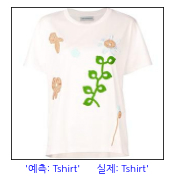

In [81]:
i = 19
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.show()